# Business Problem:

- Prediction of various Forest cover types from the aforementioned categories given in the data using Cartographic variables as the target variable to get accurate predictions viable for state, private and federal agencies.
- Which one among Elevation, Slope & Aspect actually turn out to improve predictions in the best possible way?


# Understanding the variables

- The azimuth is the angular direction of the sun, measured from north in clockwise degrees from 0 to 360. An azimuth of 90 degrees is east. The default azimuth is 315 degrees (NW).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, cross_val_predict, GroupKFold
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, f1_score
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/covtype_rem_dummies.csv'
df = pd.read_csv('covtype_rem_dummies.csv')

In [3]:
df.head()

,Unnamed: 0,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Forest_Cover_Type_designation,Soil_types,Winderness_types
0,0,2596,51,3,258,0,510,221,232,148,6279,5,Soil_Type_29,Wilderness_Area_1
1,1,2590,56,2,212,-6,390,220,235,151,6225,5,Soil_Type_29,Wilderness_Area_1
2,2,2804,139,9,268,65,3180,234,238,135,6121,2,Soil_Type_12,Wilderness_Area_1
3,3,2785,155,18,242,118,3090,238,238,122,6211,2,Soil_Type_30,Wilderness_Area_1
4,4,2595,45,2,153,-1,391,220,234,150,6172,5,Soil_Type_29,Wilderness_Area_1


In [4]:
df = df.drop(columns='Unnamed: 0')
ef = df[(df['Forest_Cover_Type_designation'] == 4) | (df['Forest_Cover_Type_designation'] == 5) | (df['Forest_Cover_Type_designation'] == 6)]


In [5]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Forest_Cover_Type_designation,Soil_types,Winderness_types
0,2596,51,3,258,0,510,221,232,148,6279,5,Soil_Type_29,Wilderness_Area_1
1,2590,56,2,212,-6,390,220,235,151,6225,5,Soil_Type_29,Wilderness_Area_1
2,2804,139,9,268,65,3180,234,238,135,6121,2,Soil_Type_12,Wilderness_Area_1
3,2785,155,18,242,118,3090,238,238,122,6211,2,Soil_Type_30,Wilderness_Area_1
4,2595,45,2,153,-1,391,220,234,150,6172,5,Soil_Type_29,Wilderness_Area_1


In [ ]:
# df = df[(df['Forest_Cover_Type_designation'] == 1) | (df['Forest_Cover_Type_designation'] == 2) | (df['Forest_Cover_Type_designation'] == 3) | (df['Forest_Cover_Type_designation'] == 7)]

# doesn't give any meaning currently.

Without Transformation, it will behave like Binary Classification

That's why we run Sensitivity Analysis

Pilot Study - Pivotal Study - Then derive the best method

Summary Table of Negative and Positive findings.

Hinge Law - Measure of error

Sensitivty Analysis

Multiclass SVM

# Model Building

### Starting with model bulding now. We have written a function tailor made to our requirements over here

In [5]:
def modelis(X, method, fold):
    method = str(method)
    if method == 'minmax':
        mn = MinMaxScaler()
        X_std = mn.fit_transform(X)
        
    elif method == 'power':
        pt = PowerTransformer()
        X_std = pt.fit_transform(X)

    elif method == 'robust':
        rc = RobustScaler()
        X_std = rc.fit_transform(X)        
        
    else:
        sc = StandardScaler()
        X_std = sc.fit_transform(X)
        
    #gb = GradientBoostingClassifier()
    #nb = GaussianNB()
    lr = LogisticRegression(random_state= 0, n_jobs= -1)
    dt = DecisionTreeClassifier(criterion = 'entropy', random_state=0) # Specifying random state is to 0
    rg_dt = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth= 7)    
    #knn = KNeighborsClassifier(weights='distance')
    
    rf = RandomForestClassifier(n_estimators= 10, criterion= 'entropy', random_state=0)
    dt_bag = BaggingClassifier(base_estimator = dt, n_jobs=-1, random_state=0)
    dt_rg_bag = BaggingClassifier(base_estimator = rg_dt, n_jobs=-1, random_state=0)    
    dt_boost = AdaBoostClassifier(base_estimator= dt, n_estimators= 10, random_state=0)
    #rf_boost = AdaBoostClassifier(base_estimator= rf, n_estimators= 100, random_state=0)

    models = []
    #models.append(('Logistic', lr))
    #models.append(('Gradient_Boosting', gb))
    #models.append(('Naive_Bayes', nb))
    models.append(('Decision_Tree', dt))
    #models.append(('KNN', knn))
    models.append(('Bagged_Decision_Tree',dt_bag))
    models.append(('Boosted_Decision_Tree', dt_boost))    
    models.append(('Random_Forest', rf))
    models.append(('Bagged_RG_DT', dt_rg_bag))

    result= []
    names = []
    for name,model in models:
        if fold == 'kf':
            skf = KFold(shuffle=True, n_splits=5, random_state=0)
        elif fold == 'skf':
            skf = StratifiedKFold(shuffle=True, n_splits=5, random_state=0)
        elif fold =='gkf':
            skf = GroupKFold(n_splits = 5)
        else:
            skf = KFold(shuffle=True, n_splits=5, random_state=0)
        cv_results = cross_val_score(model, X_std, y, cv=skf, scoring='recall_weighted')
        result.append(cv_results)
        names.append(name)
        print('%s: %f, (%f)' %(name, 1-np.mean(cv_results), np.std(cv_results, ddof=1)))
    fig = plt.figure()
    plt.grid()
    fig.suptitle('Algo Comparison')
    ax = fig.add_subplot(111)
    plt.xticks(rotation=90)
    plt.boxplot(result)
    ax.set_xticklabels(names)
    plt.show()

##### Note: We are not using KNN because it is taking too much time to run. Hence, practically not feasible. We haven't used Naive Bayes because most of the features are having some sort of Dependency among each other. Hence, Naive Bayes will become an ineffective approach in this problem.

# Base Model

In [7]:
dummy_df = pd.get_dummies(df, drop_first=True)
X = dummy_df.drop(columns='Forest_Cover_Type_designation')
y = dummy_df['Forest_Cover_Type_designation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 123)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Logistic Regression

In [22]:
lr = LogisticRegression(random_state= 0, n_jobs= -1)

In [19]:
model_0 = lr.fit(X_train_std, y_train)
y_pred_0 = model_0.predict(X_test_std)

In [50]:
print(classification_report(y_test, y_pred_0))

              precision    recall  f1-score   support

           1       0.71      0.70      0.70     42333
           2       0.75      0.80      0.77     56732
           3       0.67      0.81      0.73      7058
           4       0.62      0.38      0.47       595
           5       0.16      0.00      0.01      1875
           6       0.50      0.26      0.34      3503
           7       0.73      0.57      0.64      4107

    accuracy                           0.72    116203
   macro avg       0.59      0.50      0.52    116203
weighted avg       0.71      0.72      0.71    116203



In [51]:
print('Training Score',model_0.score(X_train_std, y_train))
print('Testing Score',model_0.score(X_test_std, y_test))

Training Score 0.7242006931879547
Testing Score 0.7243788886689673


## Decision Tree & Regularized Decision Tree

In [23]:
dt = DecisionTreeClassifier(random_state = 0, criterion='entropy')
model_1 = dt.fit(X_train_std, y_train)
y_pred_1 = model_1.predict(X_test_std)

In [24]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           1       0.94      0.94      0.94     42333
           2       0.95      0.95      0.95     56732
           3       0.93      0.94      0.93      7058
           4       0.87      0.84      0.85       595
           5       0.85      0.84      0.85      1875
           6       0.88      0.89      0.89      3503
           7       0.95      0.95      0.95      4107

    accuracy                           0.94    116203
   macro avg       0.91      0.91      0.91    116203
weighted avg       0.94      0.94      0.94    116203



In [25]:
print('Training Score',model_1.score(X_train_std, y_train))
print('Testing Score',model_1.score(X_test_std, y_test))

Training Score 1.0
Testing Score 0.9427983786993451


In [108]:
from sklearn.metrics import recall_score

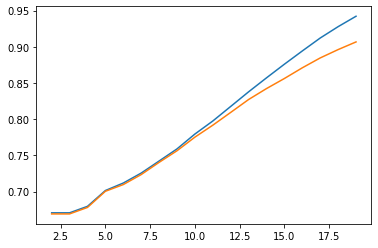

In [116]:
tesi = []
tri = []
for i in range(2,20):
    dt1 = DecisionTreeClassifier(random_state = 0, max_depth = i, criterion='entropy')
    model = dt1.fit(X_train_std, y_train)
    y_pred_2 = model.predict(X_test_std)
    tri.append(model.score(X_train_std, y_train))
    tesi.append(model.score(X_test_std, y_test))
a = [i for i in range(2,20)]
plt.plot(a, tri)
plt.plot(a, tesi)
plt.show()

For `max_depth = 6`, we get the least difference between training and testing accuracies as `0.001050`.


In [135]:
dt1 = DecisionTreeClassifier(random_state = 0, max_depth = 6, criterion='entropy')
model_2 = dt1.fit(X_train_std, y_train)
y_pred_2 = model_2.predict(X_test_std)

In [136]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           1       0.68      0.71      0.69     42333
           2       0.74      0.77      0.76     56732
           3       0.70      0.77      0.73      7058
           4       0.57      0.62      0.59       595
           5       0.48      0.20      0.29      1875
           6       0.56      0.21      0.30      3503
           7       0.76      0.38      0.51      4107

    accuracy                           0.71    116203
   macro avg       0.64      0.52      0.55    116203
weighted avg       0.71      0.71      0.70    116203



In [137]:
print('Training Score',model_2.score(X_train_std, y_train))
print('Testing Score',model_2.score(X_test_std, y_test))

Training Score 0.7118988659858135
Testing Score 0.7097837405230502


In [156]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Forest_Cover_Type_designation',
       'Soil_types', 'Winderness_types'],
      dtype='object')

## Random Forest

In [145]:
rf = RandomForestClassifier(random_state = 0, n_jobs=-1,criterion='entropy')
model_3 = rf.fit(X_train_std, y_train)
y_pred_3 = model_3.predict(X_test_std)


In [30]:
print('Training Score:',model_3.score(X_train_std, y_train))
print('Testing Score:',model_3.score(X_test_std, y_test))

Training Score: 0.999995697157327
Testing Score: 0.9574623718836863


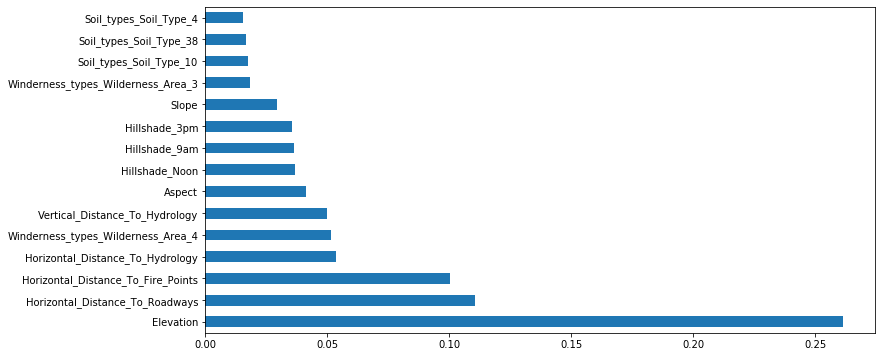

In [146]:
plt.figure(figsize=(12,6))
pd.DataFrame(model_3.feature_importances_, index = X_train.columns)[0].sort_values(ascending=False)[:15].plot(kind='barh')
plt.show()

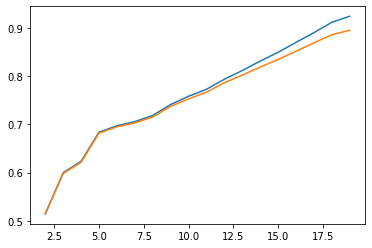

In [132]:
tesi = []
tri = []
for i in range(2,20):
    rf = RandomForestClassifier(random_state = 0, n_jobs=-1,criterion='entropy', max_depth = i)
    model = rf.fit(X_train_std, y_train)
    y_pred_2 = model.predict(X_test_std)
    tri.append(model.score(X_train_std, y_train))
    tesi.append(model.score(X_test_std, y_test))
a = [i for i in range(2,20)]
plt.plot(a, tri)
plt.plot(a, tesi)
plt.show()

In [133]:
np.min(abs(pd.Series(tri)-pd.Series(tesi)))

0     0.000055
1     0.001581
2     0.002145
3     0.001848
4     0.002147
5     0.002662
6     0.003088
7     0.003886
8     0.005379
9     0.005986
10    0.007225
11    0.009426
12    0.012438
13    0.014799
14    0.018426
15    0.021139
16    0.025864
17    0.029104
dtype: float64

In [134]:
np.min(abs(pd.Series(tri)-pd.Series(tesi)))

5.49518624963774e-05

In [139]:
rf_rg = RandomForestClassifier(random_state = 0, n_jobs=-1,criterion='entropy', max_depth = 6)
model_4 = rf_rg.fit(X_train_std, y_train)
y_pred_4 = model_4.predict(X_test_std)


In [140]:
print(classification_report(y_test, y_pred_4))

              precision    recall  f1-score   support

           1       0.67      0.69      0.68     42333
           2       0.72      0.81      0.76     56732
           3       0.63      0.76      0.69      7058
           4       1.00      0.00      0.01       595
           5       0.00      0.00      0.00      1875
           6       0.00      0.00      0.00      3503
           7       1.00      0.00      0.01      4107

    accuracy                           0.69    116203
   macro avg       0.57      0.32      0.31    116203
weighted avg       0.67      0.69      0.66    116203



In [141]:
print('Training Score:',model_4.score(X_train_std, y_train))
print('Testing Score:',model_4.score(X_test_std, y_test))

Training Score: 0.6971465698813921
Testing Score: 0.6949992685214668


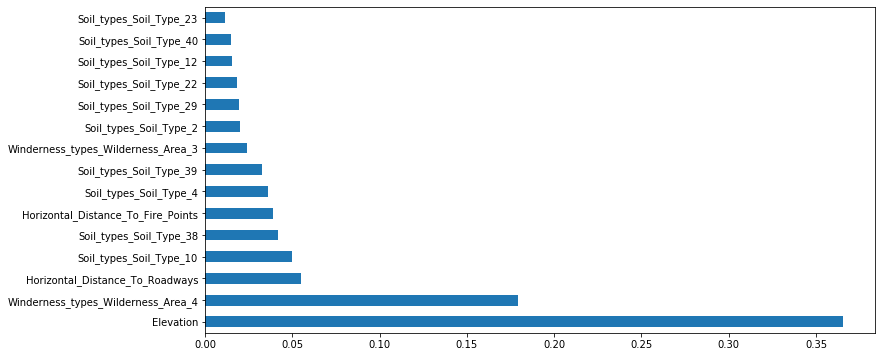

In [147]:
plt.figure(figsize=(12,6))
pd.DataFrame(model_4.feature_importances_, index = X_train.columns)[0].sort_values(ascending=False)[:15].plot(kind='barh')
plt.show()

Decision_Tree: 0.055792, (0.000829)
Bagged_Decision_Tree: 0.034813, (0.000764)
Boosted_Decision_Tree: 0.055796, (0.000664)
Random_Forest: 0.055343, (0.000839)
Bagged_RG_DT: 0.270056, (0.001807)


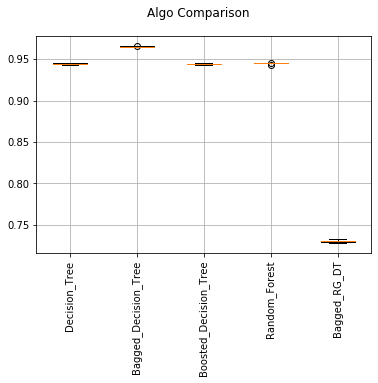

In [46]:
modelis(X, method = 'robust', fold= 'skf')

Decision_Tree: 0.056164, (0.000427)
Bagged_Decision_Tree: 0.035311, (0.000356)
Boosted_Decision_Tree: 0.056297, (0.000444)
Random_Forest: 0.054925, (0.000301)
Bagged_RG_DT: 0.270158, (0.002018)


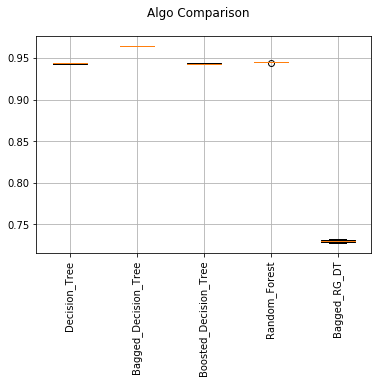

In [48]:
modelis(X, method = 'sc', fold= 'kf')

Decision_Tree: 0.055842, (0.000900)
Bagged_Decision_Tree: 0.034848, (0.000809)
Boosted_Decision_Tree: 0.055842, (0.000733)
Random_Forest: 0.055424, (0.000891)
Bagged_RG_DT: 0.270055, (0.001808)


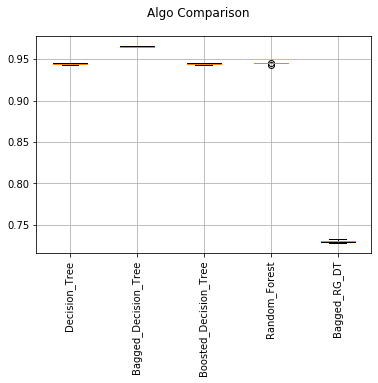

In [49]:
modelis(X, method = 'sc', fold= 'skf')

Decision_Tree: 0.056133, (0.000355)
Bagged_Decision_Tree: 0.035337, (0.000444)
Boosted_Decision_Tree: 0.056259, (0.000355)
Random_Forest: 0.054930, (0.000278)
Bagged_RG_DT: 0.270154, (0.002018)


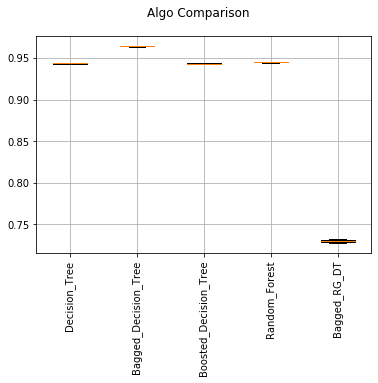

In [50]:
modelis(X, method = 'minmax', fold= 'kf')

## Base Model

Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)


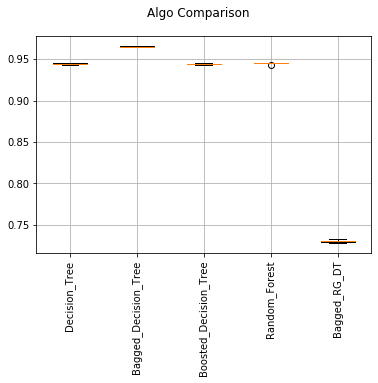

In [51]:
modelis(X, method = 'minmax', fold= 'skf')

Decision_Tree: 0.056149, (0.000383)
Bagged_Decision_Tree: 0.035306, (0.000406)
Boosted_Decision_Tree: 0.056278, (0.000488)
Random_Forest: 0.054835, (0.000383)
Bagged_RG_DT: 0.270154, (0.002017)


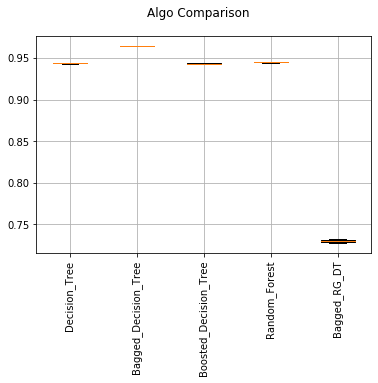

In [52]:
modelis(X, method = 'power', fold= 'kf')

Decision_Tree: 0.055844, (0.000933)
Bagged_Decision_Tree: 0.034793, (0.000777)
Boosted_Decision_Tree: 0.055865, (0.000736)
Random_Forest: 0.055415, (0.000893)
Bagged_RG_DT: 0.270058, (0.001807)


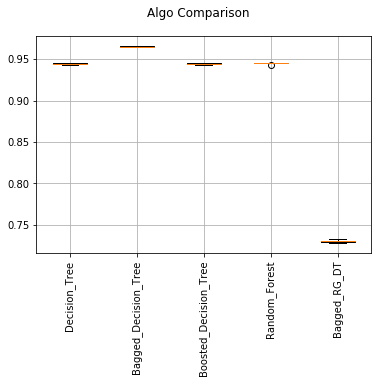

In [53]:
modelis(X, method = 'power', fold= 'skf')

#### Naive Bayes being the most underperforming model over here. Since, it is based on the Assumption that all features are independent which in our case is certainly not.

#### We aren't using Logistic Regression over here. Since, less than  50-60% of all combinations in the correlation matrix are highly correlated i.e. greater than 0.5

### MinMax Scaler + Stratified K - Fold will be used as the Base Model for our Analysis

In [12]:
def modelis2(data, method, fold):
    dummy_feat = pd.get_dummies(data, drop_first=True)
    X = dummy_feat.drop(columns='Forest_Cover_Type_designation')
    y = dummy_feat['Forest_Cover_Type_designation']
    modelis(X, method, fold)

In [13]:
def rf_imp(df_add_subt,i):
    dummy_feat = pd.get_dummies(df_add_subt, drop_first=True)
    X = dummy_feat.drop(columns=['Forest_Cover_Type_designation'])
    y = dummy_feat['Forest_Cover_Type_designation']

    sc= StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

    X_train_std = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
    X_test_std = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

    rf = RandomForestClassifier(random_state = 0)
    model_1 = rf.fit(X_train_std, y_train)
    pd.DataFrame(rf.feature_importances_, index = X_train.columns)[0].sort_values(ascending=False)[:i].plot(kind='barh')

# Outlier Treatment

## Analyzing Outlier Treatment Techniques through Modeling Results

### Quantile Cut

Decision_Tree: 0.060837, (0.000536)
Bagged_Decision_Tree: 0.041486, (0.000719)
Boosted_Decision_Tree: 0.060737, (0.000708)
Random_Forest: 0.063453, (0.000808)
Bagged_RG_DT: 0.278342, (0.002429)


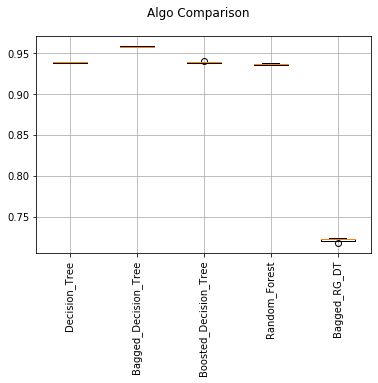

'\nBase Model:\nNaive_Bayes: 0.893098, (0.000001)\nDecision_Tree: 0.051120, (0.000001)\nBagged_Decision_Tree: 0.031982, (0.000001)\nRandom_Forest: 0.044753, (0.000001)\nBoosted_Decision_Tree: 0.050997, (0.000001)\nBagged_RG_DT: 0.225795, (0.000008)'

In [56]:
trans_data = df.copy()
trans_data.Elevation = pd.qcut(trans_data.Elevation,q=7)
modelis2(trans_data, 'minmax', 'skf')
'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

Quantile Cut is unable to perform well.

### Log Transform on Elevation

Decision_Tree: 0.055856, (0.000821)
Bagged_Decision_Tree: 0.034794, (0.000770)
Boosted_Decision_Tree: 0.055927, (0.000691)
Random_Forest: 0.055357, (0.000885)
Bagged_RG_DT: 0.270053, (0.001805)


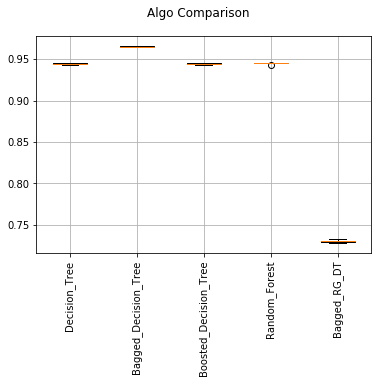

'\nBase Model:\nNaive_Bayes: 0.893098, (0.000001)\nDecision_Tree: 0.051120, (0.000001)\nBagged_Decision_Tree: 0.031982, (0.000001)\nRandom_Forest: 0.044753, (0.000001)\nBoosted_Decision_Tree: 0.050997, (0.000001)\nBagged_RG_DT: 0.225795, (0.000008)'

In [57]:
bun_data=df.copy()

bun_data['Elevation'] = np.log1p(bun_data['Elevation'])

modelis2(bun_data, 'minmax', 'skf')
'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

# Sensitivity Analysis

Firstly, we have felt that the columns Soil_types either requires `Generalization` or it needs to be `dropped out` of our analysis.

So, we have chosen to drop `Soil_types` as our first step and then we will be checking the impact of it towards modeling predictions

In [58]:
df_w_soil = df.drop(columns = 'Soil_types')

In [59]:
dummy_w_soil = pd.get_dummies(df_w_soil, drop_first=True)

In [60]:
dummy_w_soil.shape

(581012, 14)

In [61]:
dummy_w_soil.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Forest_Cover_Type_designation',
       'Winderness_types_Wilderness_Area_2',
       'Winderness_types_Wilderness_Area_3',
       'Winderness_types_Wilderness_Area_4'],
      dtype='object')

In [62]:
X = dummy_w_soil.drop(columns='Forest_Cover_Type_designation')
y = dummy_w_soil['Forest_Cover_Type_designation']


Decision_Tree: 0.066128, (0.001076)
Bagged_Decision_Tree: 0.040030, (0.000855)
Boosted_Decision_Tree: 0.066296, (0.001069)
Random_Forest: 0.056923, (0.000913)
Bagged_RG_DT: 0.275507, (0.003302)


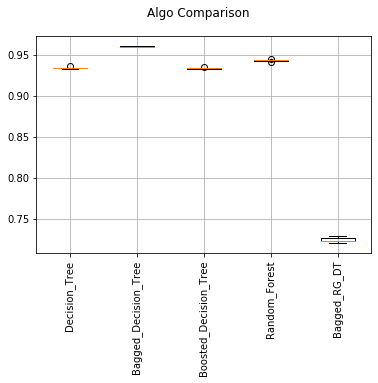

'\nBase Model:\nNaive_Bayes: 0.893098, (0.000001)\nDecision_Tree: 0.051120, (0.000001)\nBagged_Decision_Tree: 0.031982, (0.000001)\nRandom_Forest: 0.044753, (0.000001)\nBoosted_Decision_Tree: 0.050997, (0.000001)\nBagged_RG_DT: 0.225795, (0.000008)'

In [63]:
modelis(X, 'minmax', 'skf')
'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

Hence, by dropping the variable means dropping some important intelligence as none of the models are performing better than the base modelling.

The model still being Naive Bayes.

#### Therefore, dropping Soil Types was a bad decision. Hence, we will try to Generalize this column in further experiments.

# Feature Engineering

For now, we will be using the basic concept of Pythogoras theorem upon Vertical & Horizontal Distance to Hydrology to create a new feature `'Shortest_Distance_to_Hydrology'`

In [64]:
df_feat = df.copy()

In [65]:
df_feat['Shortest_Distance_to_Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)


In [66]:
df_feat.drop(columns=['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], inplace=True)

Decision_Tree: 0.056699, (0.001445)
Bagged_Decision_Tree: 0.035985, (0.000872)
Boosted_Decision_Tree: 0.056682, (0.001087)
Random_Forest: 0.060078, (0.001592)
Bagged_RG_DT: 0.269685, (0.001887)


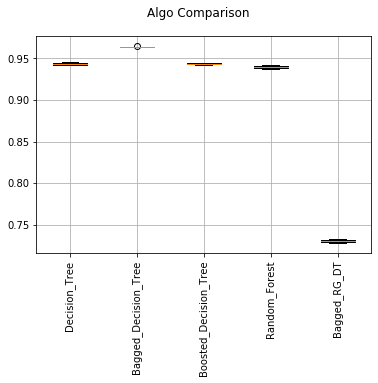

'\nBase Model:\nNaive_Bayes: 0.893098, (0.000001)\nDecision_Tree: 0.051120, (0.000001)\nBagged_Decision_Tree: 0.031982, (0.000001)\nRandom_Forest: 0.044753, (0.000001)\nBoosted_Decision_Tree: 0.050997, (0.000001)\nBagged_RG_DT: 0.225795, (0.000008)'

In [67]:
modelis2(df_feat, 'minmax', 'skf')
'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

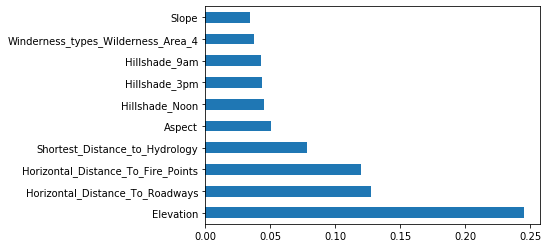

In [69]:
rf_imp(df_feat,10)

#### Naive Bayes continues to dissappoint in the predictions. The Bagged Decision Tree is a clear winner still.

The overall effect of this new feature doesn't actually make a difference in our analysis

Lets make another feature taking the means of all the 3 Hillshade index columns. Since, they are representing similar characteristics

In [52]:
df_hill_mean = df.copy()
df_hill_mean['Hillshade_mean'] = round((df['Hillshade_9am'] + df['Hillshade_Noon'] + df['Hillshade_3pm'])/3,2)
df_hill_mean.drop(columns=['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], inplace=True)
df_hill_mean.columns


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points', 'Forest_Cover_Type_designation',
       'Soil_types', 'Winderness_types', 'Hillshade_mean'],
      dtype='object')

In [71]:
df_hill_mean.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Forest_Cover_Type_designation,Soil_types,Winderness_types,Hillshade_mean
0,2596,51,3,258,0,510,6279,5,Soil_Type_29,Wilderness_Area_1,200.33
1,2590,56,2,212,-6,390,6225,5,Soil_Type_29,Wilderness_Area_1,202.00
2,2804,139,9,268,65,3180,6121,2,Soil_Type_12,Wilderness_Area_1,202.33
3,2785,155,18,242,118,3090,6211,2,Soil_Type_30,Wilderness_Area_1,199.33
4,2595,45,2,153,-1,391,6172,5,Soil_Type_29,Wilderness_Area_1,201.33


Decision_Tree: 0.054947, (0.000765)
Bagged_Decision_Tree: 0.034793, (0.000783)
Boosted_Decision_Tree: 0.054944, (0.000625)
Random_Forest: 0.047496, (0.001310)
Bagged_RG_DT: 0.268914, (0.001695)


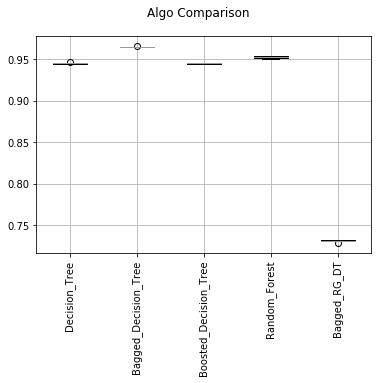

'\nBase Model:\nNaive_Bayes: 0.893098, (0.000001)\nDecision_Tree: 0.051120, (0.000001)\nBagged_Decision_Tree: 0.031982, (0.000001)\nRandom_Forest: 0.044753, (0.000001)\nBoosted_Decision_Tree: 0.050997, (0.000001)\nBagged_RG_DT: 0.225795, (0.000008)'

In [73]:
modelis2(df_hill_mean, 'minmax', 'skf')

'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

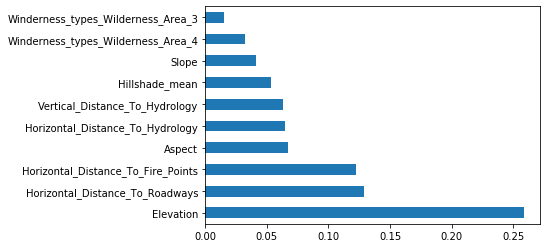

In [74]:
rf_imp(df_hill_mean,10)

##### Even after adding this feature we find no real improvement in our calculations as per the results of the base model

# Feature Engineering from Domain Knowledge

### Hillshade Algorithm

As per the Hillshade Algorithm, features like Slope should be transformed to radians first and then take its `cosine` component as new features for our analysis

Hillshade = 255.0 * ((cos(Zenith_rad) * cos(Slope_rad)) +
                 (sin(Zenith_rad) * sin(Slope_rad) * cos(Azimuth_rad - Aspect_rad)))

Reference: https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/how-hillshade-works.htm

In [53]:
df_cos = df.copy()

In [54]:
import math
df_cos['Slope_rad'] = (math.pi/180)*(df_cos['Slope'])

In [55]:
# df_sin_cos['Slope_rad_sin'] = np.sin(df_sin_cos['Slope_rad'])
df_cos['Slope_rad_cos'] = np.cos(df_cos['Slope_rad'])

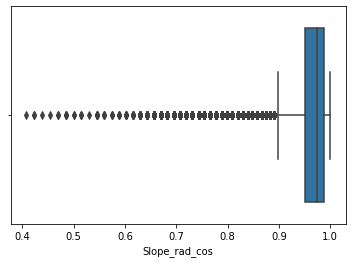

In [102]:
sns.boxplot(df_cos['Slope_rad_cos'])
plt.show()

In [56]:
df_cos.drop(columns=['Slope', 'Slope_rad'], inplace=True)

Decision_Tree: 0.055971, (0.000657)
Bagged_Decision_Tree: 0.034846, (0.000913)
Boosted_Decision_Tree: 0.055959, (0.000574)
Random_Forest: 0.053192, (0.001633)
Bagged_RG_DT: 0.270055, (0.001804)


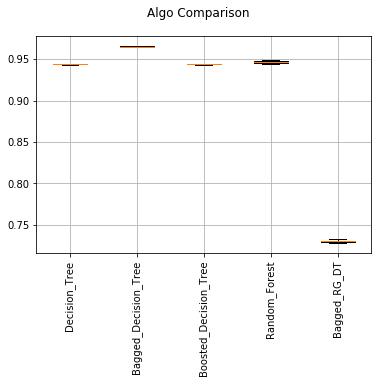

'\nBase Model:\nDecision_Tree: 0.055853, (0.000831)\nBagged_Decision_Tree: 0.034807, (0.000771)\nBoosted_Decision_Tree: 0.055933, (0.000684)\nRandom_Forest: 0.055360, (0.000898)\nBagged_RG_DT: 0.270055, (0.001804)'

In [104]:
modelis2(df_cos, 'minmax', 'skf')
'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

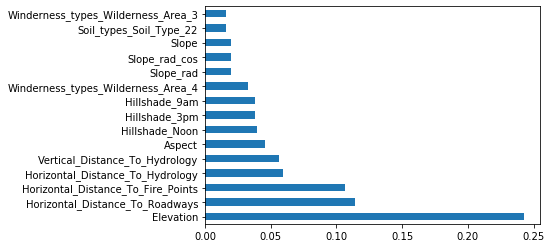

In [86]:
rf_imp(df_cos,15)

##### In this particular case, it is clear that this feature engineering has improved the results for Naive Bayes & Decision Tree.

Overall, this feature engineering might turn out to be a better one as compared to the original model.

### Adding & Subtracting Distance Features.

We can form some more features by `adding and subtracting various distances` in order to extract better intelligence as a whole.

We will also be reworking Shortest distance Feature engineering for hydrology just for experimental purposes

In [87]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Forest_Cover_Type_designation',
       'Soil_types', 'Winderness_types'],
      dtype='object')

In [57]:
df_add_subt = df.copy()
df_add_subt['Road_p_Fire'] = df_add_subt['Horizontal_Distance_To_Roadways'] + df_add_subt['Horizontal_Distance_To_Fire_Points']
df_add_subt['Road_s_Fire'] = df_add_subt['Horizontal_Distance_To_Roadways'] - df_add_subt['Horizontal_Distance_To_Fire_Points']
df_add_subt['Hyd_s_Fire'] = df_add_subt['Horizontal_Distance_To_Hydrology'] - df_add_subt['Horizontal_Distance_To_Fire_Points']
df_add_subt['Hyd_p_Fire'] = df_add_subt['Horizontal_Distance_To_Hydrology'] + df_add_subt['Horizontal_Distance_To_Fire_Points']
df_add_subt['Hyd_p_Road'] = df_add_subt['Horizontal_Distance_To_Hydrology'] + df_add_subt['Horizontal_Distance_To_Roadways']
df_add_subt['Hyd_s_Road'] = df_add_subt['Horizontal_Distance_To_Hydrology'] - df_add_subt['Horizontal_Distance_To_Roadways']
df_add_subt['Shortest_Distance_to_Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)



In [58]:
df_add_subt.drop(columns=['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology'
                          , 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points'], inplace =True)

Decision_Tree: 0.048045, (0.000279)
Bagged_Decision_Tree: 0.029836, (0.000625)
Boosted_Decision_Tree: 0.048137, (0.000202)
Random_Forest: 0.034292, (0.000493)
Bagged_RG_DT: 0.265526, (0.002274)


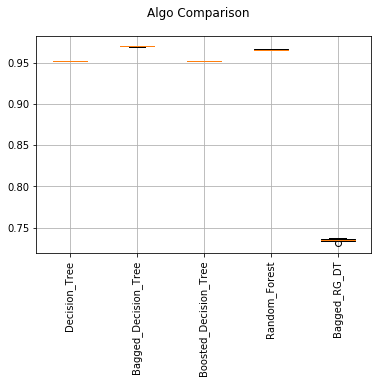

'\nBase Model:\nNaive_Bayes: 0.893098, (0.000001)\nDecision_Tree: 0.051120, (0.000001)\nBagged_Decision_Tree: 0.031982, (0.000001)\nRandom_Forest: 0.044753, (0.000001)\nBoosted_Decision_Tree: 0.050997, (0.000001)\nBagged_RG_DT: 0.225795, (0.000008)'

In [90]:
modelis2(df_add_subt, 'minmax', 'skf')

'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

##### Except Naive Bayes, all other modelling techniques have shown great promise and considerable improvement in terms of modeling predictions.

Let's have a look at Random Forest's Feature Importance to see which features among all these performed the best.

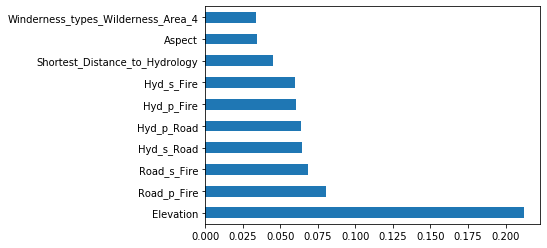

In [91]:
rf_imp(df_add_subt,10)

In [9]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Forest_Cover_Type_designation',
       'Soil_types', 'Winderness_types'],
      dtype='object')

### Exploring similar interaction between Hillshade Indexes

Let's engineer some features both on the basis of multiplication upon Hill Shadow indexes measures at 3 times

In [10]:
df_mul_sub_p = df.copy()

df_mul_sub_p['Hillshade_9am_m_Noon'] = df['Hillshade_9am'] * df['Hillshade_Noon']
df_mul_sub_p['Hillshade_3pm_m_Noon'] = df['Hillshade_Noon'] * df['Hillshade_3pm']
df_mul_sub_p['Hillshade_9am_m_3pm'] = df['Hillshade_9am'] * df['Hillshade_3pm']

df_mul_sub_p.drop(columns=['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], inplace=True)

Decision_Tree: 0.057205, (0.000398)
Bagged_Decision_Tree: 0.035922, (0.000659)
Boosted_Decision_Tree: 0.057181, (0.000646)
Random_Forest: 0.056524, (0.001112)
Bagged_RG_DT: 0.268643, (0.003075)


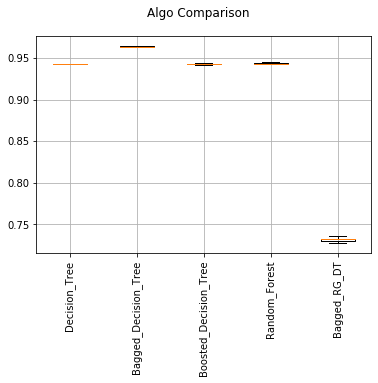

'\nBase Model:\nNaive_Bayes: 0.893098, (0.000001)\nDecision_Tree: 0.051120, (0.000001)\nBagged_Decision_Tree: 0.031982, (0.000001)\nRandom_Forest: 0.044753, (0.000001)\nBoosted_Decision_Tree: 0.050997, (0.000001)\nBagged_RG_DT: 0.225795, (0.000008)'

In [14]:
modelis2(df_mul_sub_p, 'minmax', 'skf')
'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

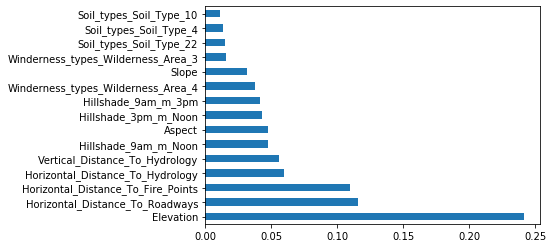

In [17]:
rf_imp(df_mul_sub_p,15)

In [18]:
df_mul_sub_p.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points', 'Forest_Cover_Type_designation',
       'Soil_types', 'Winderness_types', 'Hillshade_9am_m_Noon',
       'Hillshade_3pm_m_Noon', 'Hillshade_9am_m_3pm'],
      dtype='object')

#   Study Code USFS ELU Code			Description
- 1	   2702	1	Cathedral family - Rock outcrop complex, extremely stony.
- 2	   2703	2	Vanet - Ratake families complex, very stony.
- 3	   2704	3	Haploborolis - Rock outcrop complex, rubbly.
- 4	   2705	4	Ratake family - Rock outcrop complex, rubbly.
- 5	   2706	2	Vanet family - Rock outcrop complex complex, rubbly.
- 6	   2717	2	Vanet - Wetmore families - Rock outcrop complex, stony.
- 7	   3501	5	Gothic family.
- 8	   3502	6	Supervisor - Limber families complex.
- 9	   4201	7	Troutville family, very stony.
- 10	 4703  8	Bullwark - Catamount families - Rock outcrop complex, rubbly.
- 11	   4704	8	Bullwark - Catamount families - Rock land complex, rubbly.
- 12	   4744	9	Legault family - Rock land complex, stony.
- 13	   4758	10	Catamount family - Rock land - Bullwark family complex, rubbly.
- 14	   5101	11	Pachic Argiborolis - Aquolis complex.
- 15	   5151	12	unspecified in the USFS Soil and ELU Survey.
- 16	   6101	13 	Cryaquolis - Cryoborolis complex.
- 17	   6102	14	Gateview family - Cryaquolis complex.
- 18	   6731	15	Rogert family, very stony.
- 19	   7101	13	Typic Cryaquolis - Borohemists complex.
- 20	   7102	14	Typic Cryaquepts - Typic Cryaquolls complex.
- 21	   7103 15	Typic Cryaquolls - Leighcan family, till substratum complex.
- 22	   7201	16	Leighcan family, till substratum, extremely bouldery.
- 23	   7202	16	Leighcan family, till substratum - Typic Cryaquolls complex.
- 24	   7700	16	Leighcan family, extremely stony.
- 25	   7701	16	Leighcan family, warm, extremely stony.
- 26	   7702	17	Granile - Catamount families complex, very stony.
- 27	   7709	16	Leighcan family, warm - Rock outcrop complex, extremely stony.
- 28	   7710	16	Leighcan family - Rock outcrop complex, extremely stony.
- 29	   7745	18	Como - Legault families complex, extremely stony.
- 30	   7746	18	Como family - Rock land - Legault family complex, extremely stony.
- 31	   7755	16	Leighcan - Catamount families complex, extremely stony.
- 32	   7756	10	Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
- 33	   7757	16	Leighcan - Catamount families - Rock outcrop complex, extremely stony.
- 34	   7790	19	Cryorthents - Rock land complex, extremely stony.
- 35	   8703	20	Cryumbrepts - Rock outcrop - Cryaquepts complex.
- 36	   8707	21	Bross family - Rock land - Cryumbrepts complex, extremely stony.
- 37	   8708	20	Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
- 38	   8771	16	Leighcan - Moran families - Cryaquolls complex, extremely stony.
- 39	   8772	19	Moran family - Cryorthents - Leighcan family complex, extremely stony.
- 40	   8776	19	Moran family - Cryorthents - Rock land complex, extremely stony.

`Reference Link`: https://archive.ics.uci.edu/ml/datasets/covertype

# Generalizing Soil Types

- On the basis of Soil texture, we are trying this feature engineering. Since, family is not what effects any of our Hillshading Indexes or Geo Spatial Data but the texture of Soil will definitely have some impact on the Hillshading Parameters

In [59]:
cat = df.select_dtypes(include='object')
le = LabelEncoder()
for i in cat.columns:
    cat[i] = le.fit_transform(cat[i])+1
cat['Forest_Cover_Type_designation'] = df['Forest_Cover_Type_designation']
cat.head()

,Soil_types,Winderness_types,Forest_Cover_Type_designation
0,22,1,5
1,22,1,5
2,4,1,2
3,24,1,2
4,22,1,5


In [60]:
stony = {1,2,6,9,12,18, 24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40}
others = {7,8,14,15,16,17,19,20, 21, 22,23,35}
rubble = {i for i in range(1,41)}-stony-others
rubble

{3, 4, 5, 10, 11, 13}

In [61]:
val = [1, 2, 3, 4, 2, 2, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 13, 14, 15, 16, 16, 16,16, 17, 16, 16, 18, 18, 16, 10, 16, 19, 20, 21, 20, 16, 19, 19]
sorted(df['Soil_types'].unique())

['Soil_Type_1',
 'Soil_Type_10',
 'Soil_Type_11',
 'Soil_Type_12',
 'Soil_Type_13',
 'Soil_Type_14',
 'Soil_Type_15',
 'Soil_Type_16',
 'Soil_Type_17',
 'Soil_Type_18',
 'Soil_Type_19',
 'Soil_Type_2',
 'Soil_Type_20',
 'Soil_Type_21',
 'Soil_Type_22',
 'Soil_Type_23',
 'Soil_Type_24',
 'Soil_Type_25',
 'Soil_Type_26',
 'Soil_Type_27',
 'Soil_Type_28',
 'Soil_Type_29',
 'Soil_Type_3',
 'Soil_Type_30',
 'Soil_Type_31',
 'Soil_Type_32',
 'Soil_Type_33',
 'Soil_Type_34',
 'Soil_Type_35',
 'Soil_Type_36',
 'Soil_Type_37',
 'Soil_Type_38',
 'Soil_Type_39',
 'Soil_Type_4',
 'Soil_Type_40',
 'Soil_Type_5',
 'Soil_Type_6',
 'Soil_Type_7',
 'Soil_Type_8',
 'Soil_Type_9']

In [62]:
key = ['Soil_Type_1',
 'Soil_Type_2',
 'Soil_Type_3', 
 'Soil_Type_4',
 'Soil_Type_5',
 'Soil_Type_6',
 'Soil_Type_7',
 'Soil_Type_8',
 'Soil_Type_9',    
 'Soil_Type_10',
 'Soil_Type_11',
 'Soil_Type_12',
 'Soil_Type_13',
 'Soil_Type_14',
 'Soil_Type_15',
 'Soil_Type_16',
 'Soil_Type_17',
 'Soil_Type_18',
 'Soil_Type_19',
 'Soil_Type_20',
 'Soil_Type_21',
 'Soil_Type_22',
 'Soil_Type_23',
 'Soil_Type_24',
 'Soil_Type_25',
 'Soil_Type_26',
 'Soil_Type_27',
 'Soil_Type_28',
 'Soil_Type_29',
 'Soil_Type_30',
 'Soil_Type_31',
 'Soil_Type_32',
 'Soil_Type_33',
 'Soil_Type_34',
 'Soil_Type_35',
 'Soil_Type_36',
 'Soil_Type_37',
 'Soil_Type_38',
 'Soil_Type_39',
 'Soil_Type_40']
family_dict = dict(zip(key,val))

In [63]:
cat['Soil_types_bin'] = cat['Soil_types'].apply(lambda x: 'rubble' if x in rubble else 'others' if x in others else 'stony')


In [64]:
cat['Soil_types_bin']

0         others
1         others
2         rubble
3          stony
4         others
           ...  
581007     stony
581008     stony
581009     stony
581010     stony
581011     stony
Name: Soil_types_bin, Length: 581012, dtype: object

In [65]:
df_soil_bin = df.copy()
df_soil_bin['Soil_types_bin'] = cat['Soil_types_bin']
df_soil_bin['Soil_families'] = df['Soil_types'].map(family_dict)
df_soil_bin['Soil_families'] = df_soil_bin['Soil_families'].apply(lambda x: str(x))
df_soil_bin.drop(columns='Soil_types', inplace = True)

In [50]:
df_soil_bin.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Forest_Cover_Type_designation,Winderness_types,Soil_types_bin,Soil_families
0,2596,51,3,258,0,510,221,232,148,6279,5,Wilderness_Area_1,others,18
1,2590,56,2,212,-6,390,220,235,151,6225,5,Wilderness_Area_1,others,18
2,2804,139,9,268,65,3180,234,238,135,6121,2,Wilderness_Area_1,rubble,9
3,2785,155,18,242,118,3090,238,238,122,6211,2,Wilderness_Area_1,stony,18
4,2595,45,2,153,-1,391,220,234,150,6172,5,Wilderness_Area_1,others,18


Decision_Tree: 0.057369, (0.000744)
Bagged_Decision_Tree: 0.036171, (0.000565)
Boosted_Decision_Tree: 0.057116, (0.000916)
Random_Forest: 0.044273, (0.000933)
Bagged_RG_DT: 0.263831, (0.001377)


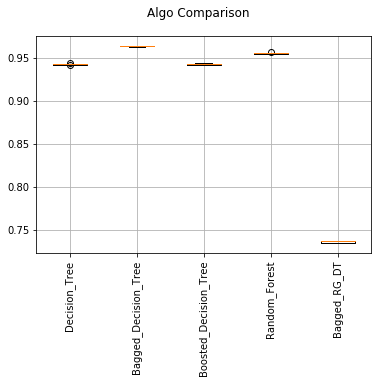

'\nBase Model:\nDecision_Tree: 0.055853, (0.000831)\nBagged_Decision_Tree: 0.034807, (0.000771)\nBoosted_Decision_Tree: 0.055933, (0.000684)\nRandom_Forest: 0.055360, (0.000898)\nBagged_RG_DT: 0.270055, (0.001804)'

In [51]:
modelis2(df_soil_bin, 'minmax', 'skf')

'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

Decision_Tree: 0.056016, (0.000780)
Bagged_Decision_Tree: 0.035788, (0.000631)
Boosted_Decision_Tree: 0.056159, (0.000493)
Random_Forest: 0.058973, (0.001339)
Bagged_RG_DT: 0.262867, (0.001181)


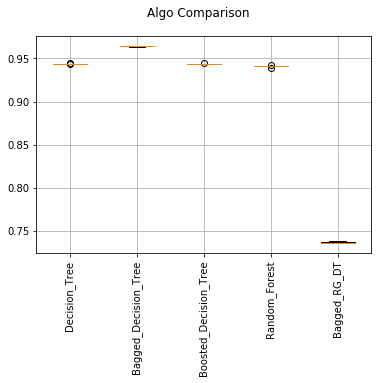

'\nBase Model:\nDecision_Tree: 0.055853, (0.000831)\nBagged_Decision_Tree: 0.034807, (0.000771)\nBoosted_Decision_Tree: 0.055933, (0.000684)\nRandom_Forest: 0.055360, (0.000898)\nBagged_RG_DT: 0.270055, (0.001804)'

In [66]:
modelis2(df_soil_bin, 'minmax', 'skf')

'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

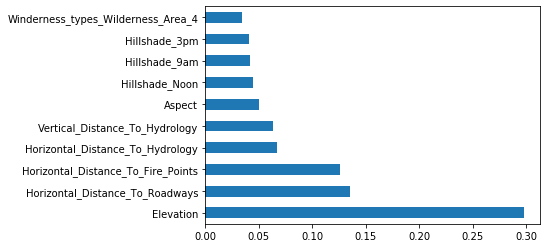

In [28]:
rf_imp(df_soil_bin,10)

# Building Final Model with Best FE features

In [73]:
df_final = df.copy()

In [74]:
df_final['Road_p_Fire'] = df_final['Horizontal_Distance_To_Roadways'] + df_final['Horizontal_Distance_To_Fire_Points']
df_final['Road_s_Fire'] = df_final['Horizontal_Distance_To_Roadways'] - df_final['Horizontal_Distance_To_Fire_Points']
df_final['Hyd_s_Fire'] = df_final['Horizontal_Distance_To_Hydrology'] - df_final['Horizontal_Distance_To_Fire_Points']
df_final['Hyd_p_Fire'] = df_final['Horizontal_Distance_To_Hydrology'] + df_final['Horizontal_Distance_To_Fire_Points']
df_final['Hyd_p_Road'] = df_final['Horizontal_Distance_To_Hydrology'] + df_final['Horizontal_Distance_To_Roadways']
df_final['Hyd_s_Road'] = df_final['Horizontal_Distance_To_Hydrology'] - df_final['Horizontal_Distance_To_Roadways']
df_final['Shortest_Distance_to_Hydrology'] = np.sqrt(df_final['Horizontal_Distance_To_Hydrology']**2 + df_final['Vertical_Distance_To_Hydrology']**2)
df_final['Slope_rad_cos'] = df_cos['Slope_rad_cos']
df_final['Hillshade_mean'] = round((df['Hillshade_9am'] + df['Hillshade_Noon'] + df['Hillshade_3pm'])/3,2)
df_final['Soil_families'] = df_soil_bin['Soil_families']
df_final['Soil_types_bin'] = df_soil_bin['Soil_types_bin']


In [75]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Forest_Cover_Type_designation',
       'Soil_types', 'Winderness_types'],
      dtype='object')

In [76]:
df_final.drop(columns=['Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points',
       'Soil_types'], inplace=True)

In [77]:
df_final.columns

Index(['Elevation', 'Aspect', 'Forest_Cover_Type_designation',
       'Winderness_types', 'Road_p_Fire', 'Road_s_Fire', 'Hyd_s_Fire',
       'Hyd_p_Fire', 'Hyd_p_Road', 'Hyd_s_Road',
       'Shortest_Distance_to_Hydrology', 'Slope_rad_cos', 'Hillshade_mean',
       'Soil_families', 'Soil_types_bin'],
      dtype='object')

Decision_Tree: 0.047457, (0.000493)
Bagged_Decision_Tree: 0.030046, (0.000554)
Boosted_Decision_Tree: 0.047524, (0.000320)
Random_Forest: 0.031371, (0.000523)
Bagged_RG_DT: 0.258348, (0.001805)


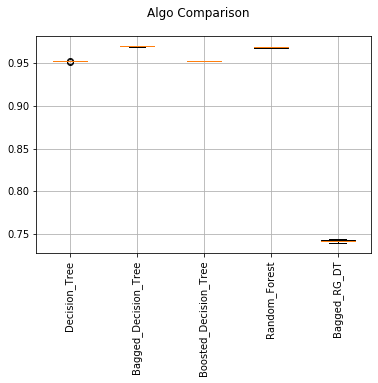

'\nBase Model:\nDecision_Tree: 0.055853, (0.000831)\nBagged_Decision_Tree: 0.034807, (0.000771)\nBoosted_Decision_Tree: 0.055933, (0.000684)\nRandom_Forest: 0.055360, (0.000898)\nBagged_RG_DT: 0.270055, (0.001804)'

In [78]:
modelis2(df_final, 'minmax', 'skf')

'''
Base Model:
Decision_Tree: 0.055853, (0.000831)
Bagged_Decision_Tree: 0.034807, (0.000771)
Boosted_Decision_Tree: 0.055933, (0.000684)
Random_Forest: 0.055360, (0.000898)
Bagged_RG_DT: 0.270055, (0.001804)'''

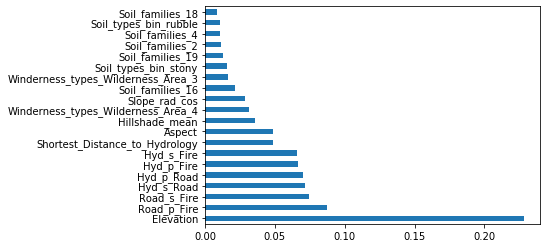

In [89]:
rf_imp(df_final, 20)

In [90]:
dummy_df_final = pd.get_dummies(df, drop_first=True)
X_final = dummy_df_final.drop(columns='Forest_Cover_Type_designation')
y_final = dummy_df_final['Forest_Cover_Type_designation']
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size= 0.2, random_state= 123)
mn = MinMaxScaler()
X_train_final_std = mn.fit_transform(X_train_final)
X_test_final_std = mn.transform(X_test_final)


In [91]:
rg_dt = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth= 7) 
dt_rg_bag = BaggingClassifier(base_estimator = rg_dt, n_jobs=-1, random_state=0)


selector = dt_rg_bag.fit(X_train_final_std, y_train_final)
y_pred_final = selector.predict(X_test_final_std)

In [92]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           1       0.70      0.72      0.71     42333
           2       0.75      0.79      0.77     56732
           3       0.71      0.82      0.76      7058
           4       0.76      0.67      0.71       595
           5       0.80      0.16      0.26      1875
           6       0.61      0.22      0.32      3503
           7       0.83      0.55      0.66      4107

    accuracy                           0.73    116203
   macro avg       0.74      0.56      0.60    116203
weighted avg       0.73      0.73      0.72    116203

